### Exploratory Research - The goal was to understand trends in taxi trips to/from JFK/LaGuardia.
1. overall number of trips
2. location distribution for trips with dropoff or pickup constrained to JFK/Laguardia
3. distribution over days
4. hourly distributions 
5. length of trip (any correlations?)

### Methods/techniques/data:
1. 2013 yellow taxi trip data 
2. BigQuery to select events with dropoff or pickup location constrained to JFK or LaGuardia (4 data sets). Longitude/latitude coordinates for the airports "box" were estimated using Google Maps API, e.g. 
SELECT rate_code, pickup_datetime, dropoff_datetime,
  passenger_count, trip_time_in_secs, 
  pickup_longitude, pickup_latitude
  FROM [imjasonh-storage:nyctaxi.trip_data]
  where date(dropoff_datetime) < '2014-01-01'
  and float(dropoff_longitude) < -73.776283 and float(dropoff_longitude) > -73.794694
  and float(dropoff_latitude) < 40.651381 and float(dropoff_latitude) > 40.640668
  
3. Zillow Neighborhood API was used to determine the neighborhoods under consideration  
4. PostGIS was used for assigning data points to neighborhoods
5. Python for the rest

### Figures:
Data 'maps':
JFK_dropoff - dropoff location at JFK
JFK_pickup - pickup location at JFK
LaGuardia_dropoff - the same as above but LaGuardia
LaGuardia_pickup
ZillowManhattan - overlap of data with Zillow neighborhoods
Fig00 - pickup time vs length of trip in minutes, events integrated over all neighborhoos and a year
Fig01 - daily distribution by neighborhood
Fig02 - weekday bar plots, counts/trips per day (from Monday - Sunday, 0-7, respectively)
Fig03 - hourly distribution of counts/trips in a day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
%matplotlib inline

pd.set_option('max_columns',200)
pd.set_option('max_rows',500)

In [3]:
def str_to_datetime(df):
    """Return datetime object"""
    return df.astype('datetime64[ns]')

In [4]:
def datetime_to_weekday(df):
    """Return datetime as day of week, e.g. Monday"""
    return df.dt.weekday_name

In [5]:
def datetime_hour(ts):
    """Return hour from datetime"""
    return ts.hour

In [6]:
def Dist_2D(X,Y):
    """Plots 2D scatter and projections"""
    with sns.axes_style("white"):
        sns.jointplot(x,y,kind="hex")

In [7]:
def plot_bar(series_,timegate):
    """Bar plot of a series"""
    
    if timegate:
        y = series_/365.
    else:
        y = series_
        
    plt.figure(figsize=(10,6))
    plt.bar(range(len(series_)),y, align='center')
    plt.xticks(range(len(series_.index.tolist())),series_.index.tolist(), rotation=90)
    plt.title(series_.index.name)
    plt.ylabel('Number of rides')
    plt.axis('tight')
    plt.grid()
    #plt.show()

In [8]:
def normalize(series_,index_):
    """Normalization for daily counts"""
    
    mask = series_.index.isin([index_])
    s1 = series_.loc[~mask]/52.    #52 weeks in a year
    s2 = series_.loc[mask]/53.     # one day occurs 53 considering a 365 days long year (Tuesday in 2013)
    return pd.concat([s1,s2], axis=0)

In [9]:
def sort_pd(key=None,reverse=False,cmp=None):
    """Sort by index"""
    
    def sorter(series):
        series_list = list(series)
        
        return [series_list.index(i) for i in sorted(series_list,key=key,reverse=reverse,cmp=cmp)]
    return sorter

In [10]:
def sorted_days(list_,series_,sorting_index):
    """Return days sorted from Monday to Sunday"""
    
    sort_by_day = sort_pd(key = list_.index)
    return series_.iloc[sort_by_day(series_.index.get_level_values(sorting_index))]

In [11]:
def bar_plot(level1_,level2_, series_,timegate):
    """Makes bar plot for group level2"""
    
    fig, axs = plt.subplots(7,4, figsize=(20, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.16)

    axs = axs.ravel()

    for i,j in enumerate(level1_):
        if timegate:
            norm = normalize(series_[j],'Tuesday')
            Y = sorted_days(level2_,norm,series_.index.names[1])
        else:
            Y = sorted_days(level2_,series_[j],series_.index.names[1])
        
        X = range(1, len(level2_) + 1)
    
        axs[i].bar(X,Y)
        axs[i].set_title(j)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].yaxis.set_ticks_position('left')
        axs[i].xaxis.set_ticks_position('bottom')

In [12]:
def date_to_abbr(day):
    """Return abbreviation of day names"""
    
    abbr = {'Monday':'Mon', 'Tuesday':'Tue', 'Wednesday':'Wed', 'Thursday':'Thu', 'Friday':'Fri', 'Saturday':'Sat',\
            'Sunday':'Sun'}
    
    return abbr[day]

In [13]:
def days():
    """Return list of days in ascending order"""
    
    return ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [14]:
def time_plot(level1_,level2_, series_,timegate):
    """Level2 distributions"""
    
    fig, axs = plt.subplots(7,4, figsize=(20, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.001)

    axs = axs.ravel()

    for i,j in enumerate(level1_):
        for k in level2_:
            
            X = series_[j][k].index
            if timegate:
                if k != 'Tuesday':
                    Y = series_[j][k]/52.    #52 weeks in a year
                else:
                    Y = series_[j][k]/53.    # 2013 started on Tuesday => 53 Tuesdays in the year
            else:
                Y = series_[j][k]
                
            axs[i].plot(X, Y,label = date_to_abbr(k))
            axs[i].set_title(j)
            axs[i].legend(loc = 'upper left', labelspacing = 0.1, handlelength = 0.2, frameon = False)
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['top'].set_visible(False)
            axs[i].yaxis.set_ticks_position('left')
            axs[i].xaxis.set_ticks_position('bottom')

In [15]:
def trip_length_time_corr(s1,s2):
    """Trip furation vs pickup time"""
    
    plt.figure(figsize=(10,6))
    plt.hist2d(s1,s2/60.,bins=24,range=[[0,23],[0.,200]],norm=LogNorm())
    plt.xlabel('Pickup hour')
    plt.ylabel('Trip time (min)')
    plt.title('Hourly distribution of trip time')
    plt.colorbar()
    plt.show()

In [16]:
def main():
    
    files = !ls *.csv 
    print files
    dfs = [pd.read_csv(file_) for file_ in files]
    for i, df in enumerate(dfs):
        df['pickup_datetime'] = str_to_datetime(df['pickup_datetime'])
        df['dropoff_datetime'] = str_to_datetime(df['dropoff_datetime'])
        df['day_of_week'] = datetime_to_weekday(df['pickup_datetime'])
        df['day_num'] = df['day_of_week'].replace(to_replace = days(), value = range(1,8))
        df['pickup_hour'] = df['pickup_datetime'].apply(datetime_hour)
        manhattan = df[df['city'] == 'New York City-Manhattan']
       
        print 'Filename: ', files[i]
        trip_length_time_corr(manhattan['pickup_hour'],manhattan['trip_time_in_secs'])
        
        yearlyNBHD = manhattan.groupby(['neighboorhood'])['day_of_week'].count()
        NBHDs = yearlyNBHD.index.tolist()
        plot_bar(yearlyNBHD, True)
        plt.savefig('Fig01_' + files[i].strip('csv') + 'png')
        
        hour_NBHD = manhattan.groupby(['neighboorhood','day_of_week','pickup_hour'])['passenger_count'].count()
        time_plot(NBHDs, days(), hour_NBHD, True)
        plt.savefig('Fig03_day_' + files[i].strip('csv') + 'png')
            
        

['neighborhood_jfk_dropoff.csv', 'neighborhood_jfk_pickup.csv', 'neighborhood_laguardia_dropoff.csv', 'neighborhood_laguardia_pickup.csv']
Filename:  neighborhood_jfk_dropoff.csv


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


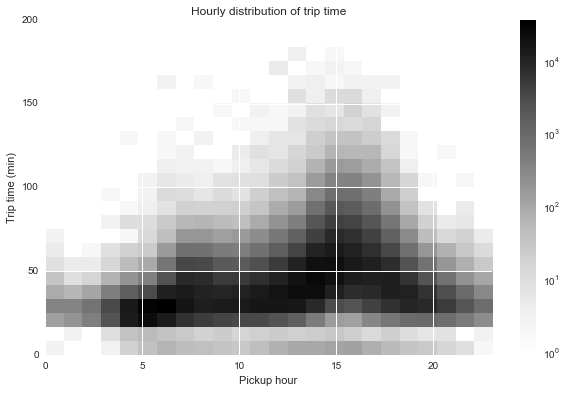

Filename:  neighborhood_jfk_pickup.csv


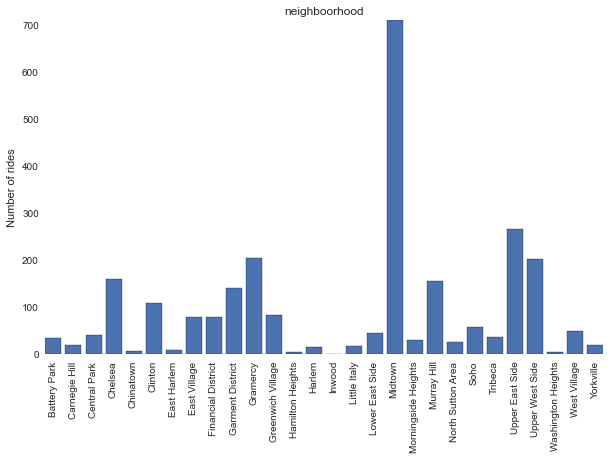

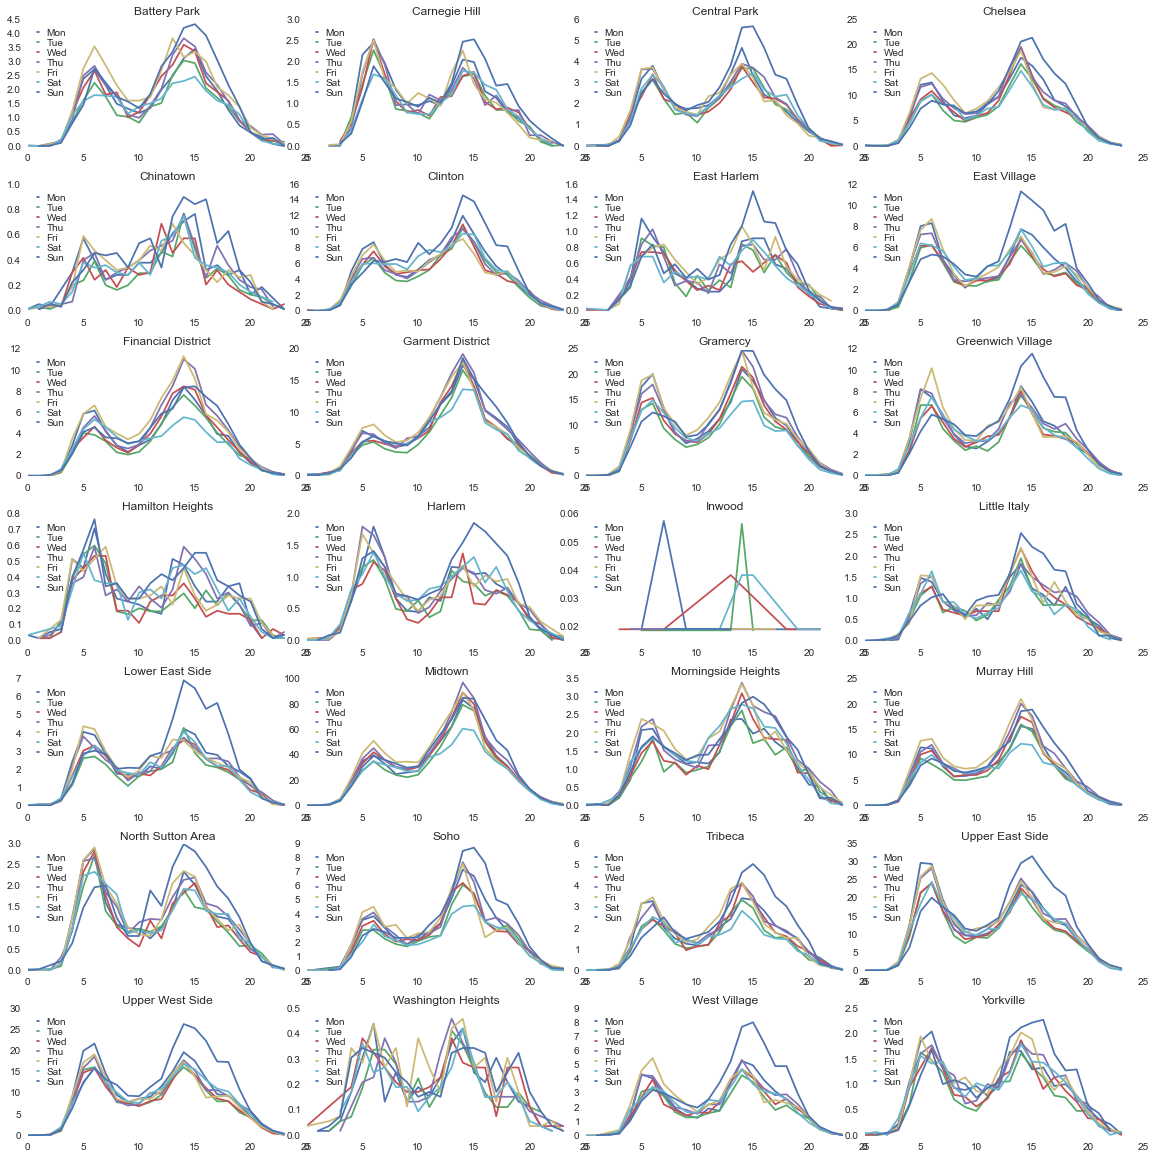

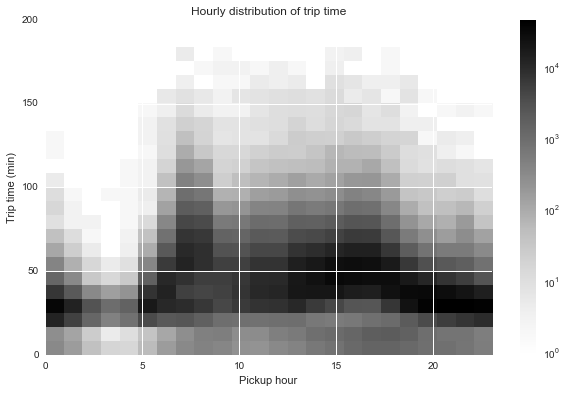

Filename:  neighborhood_laguardia_dropoff.csv


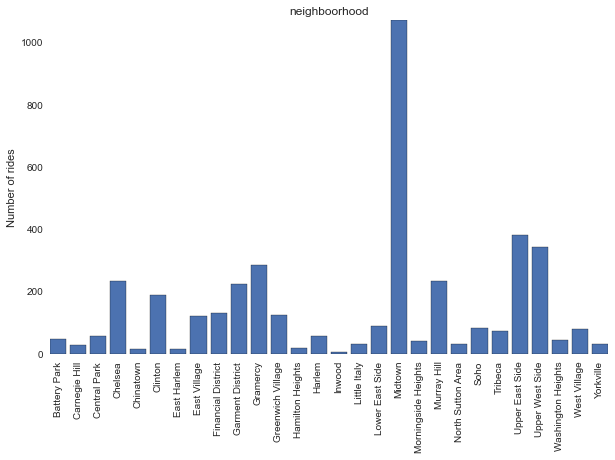

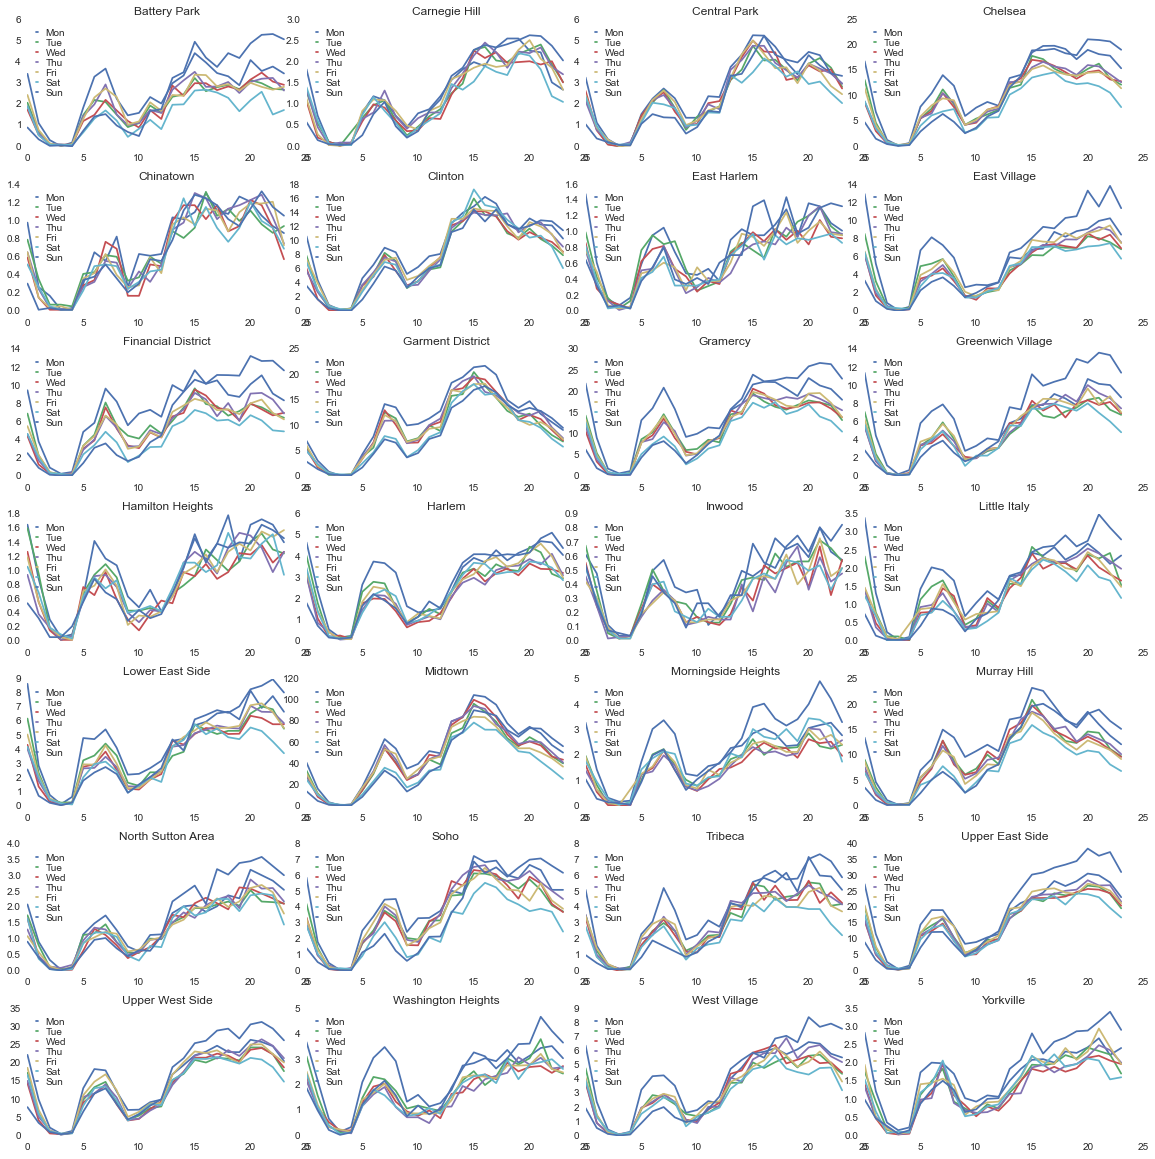

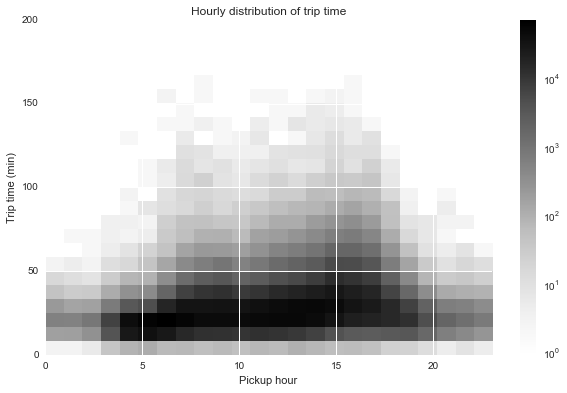

Filename:  neighborhood_laguardia_pickup.csv


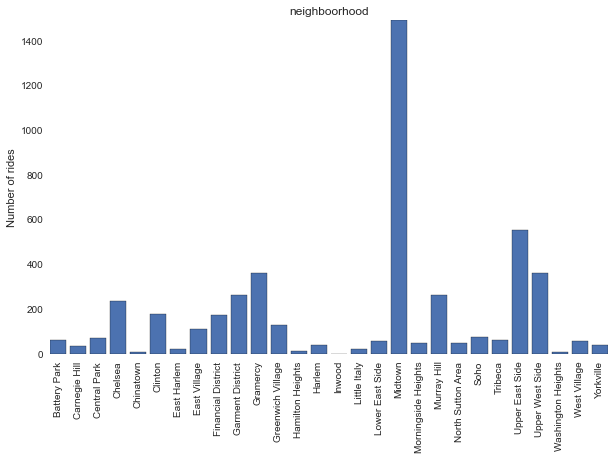

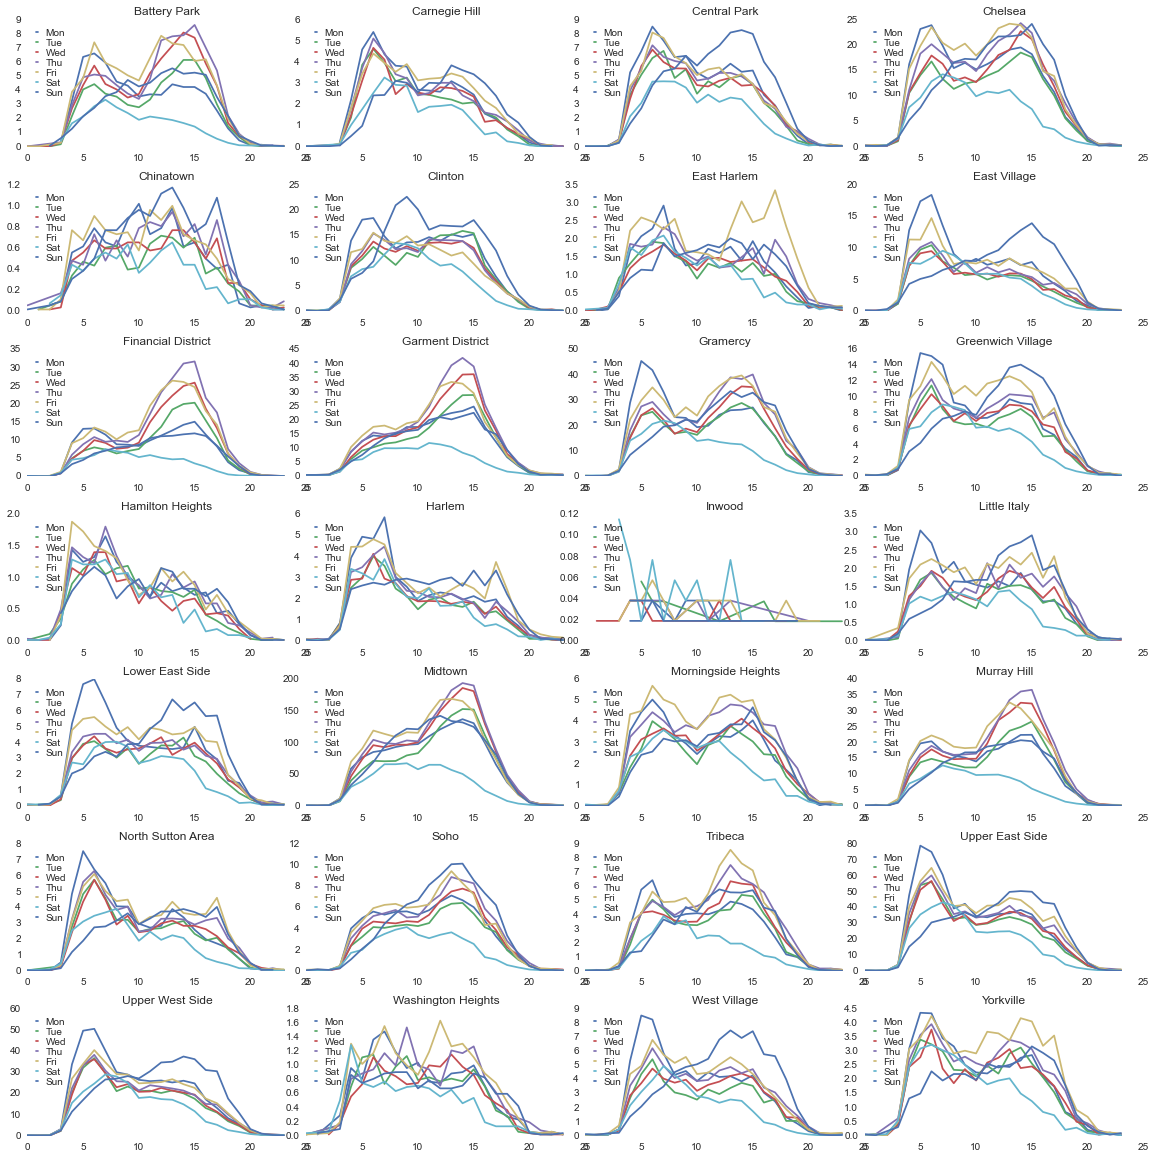

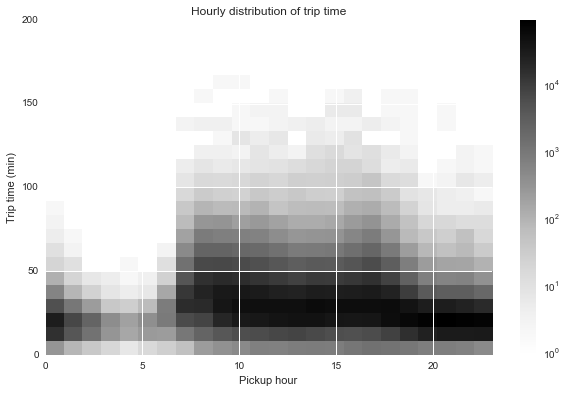

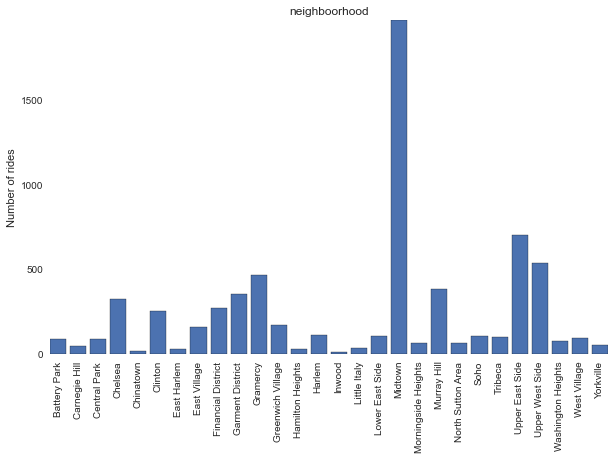

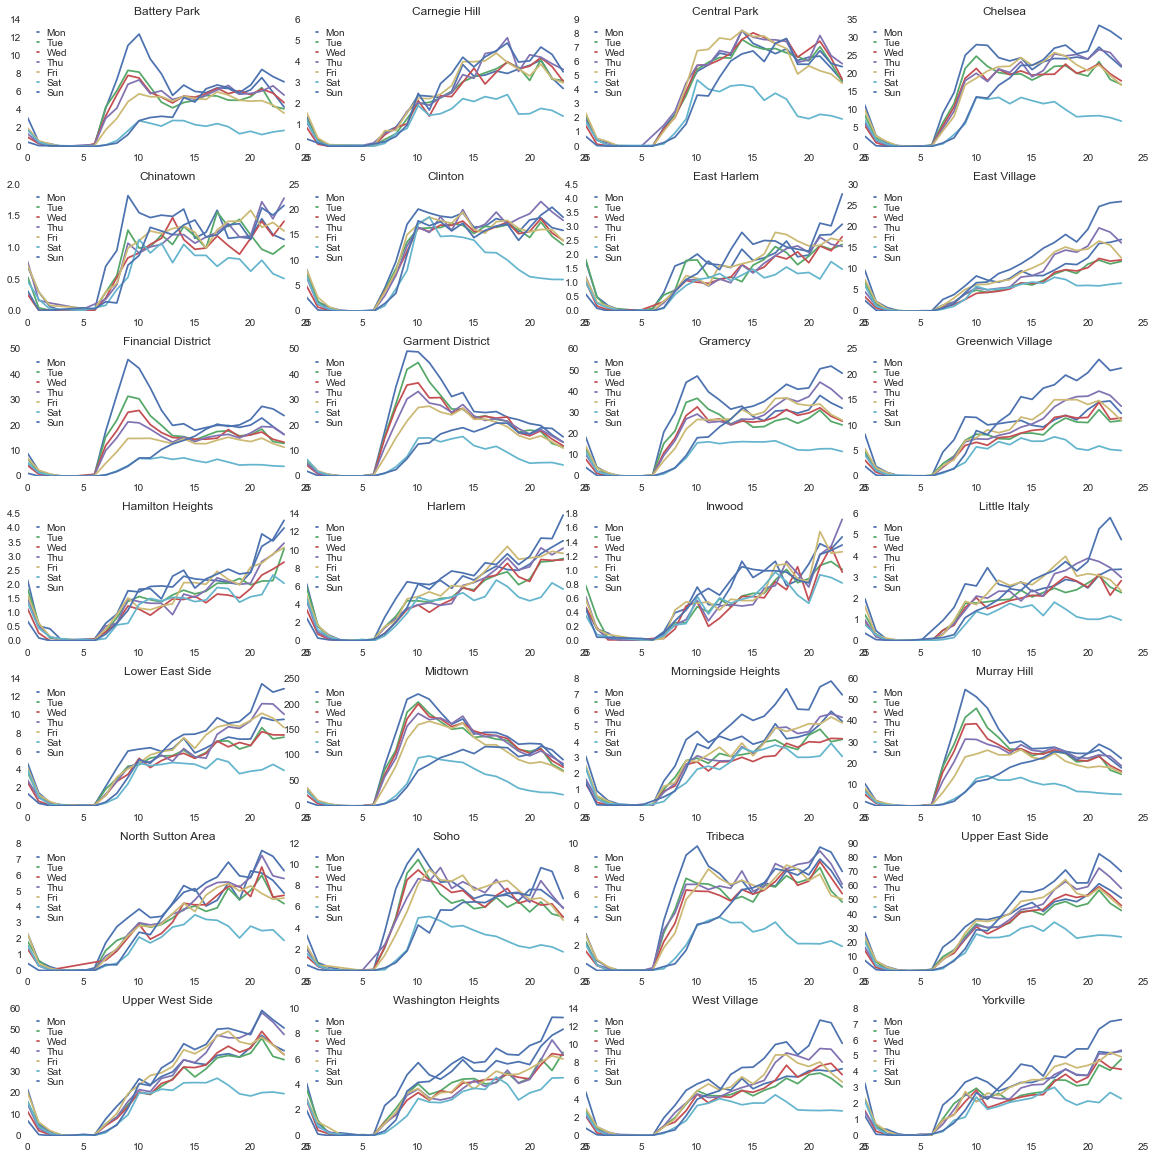

In [17]:
if __name__ == '__main__':
    main()